In [128]:
import numpy as np
import pandas as pd

from scipy import spatial, stats, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.datasets import fetch_atlas_schaefer_2018

import networkx as nx

import matplotlib.cm as mplcm
import matplotlib.colors as colors
import bct
import glob
import community as community_louvain
import matplotlib.cm as cm
from sklearn.metrics import adjusted_rand_score
import os
import random
import itertools

%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [2]:
dfLabels = pd.read_csv("../resources/aal_extended.csv",header=None) 
dfLabels.columns = ['reindex','name','mark','region','side']
dfLabels["region_side"] = dfLabels["region"] + "_" + dfLabels["side"]

print(dfLabels.head())

labels = dfLabels['name'].values

   reindex               name  mark   region side region_side
0        1       Precentral_L  2001  Central    L   Central_L
1        2       Precentral_R  2002  Central    R   Central_R
2        3      Frontal_Sup_L  2101  Frontal    L   Frontal_L
3        4      Frontal_Sup_R  2102  Frontal    R   Frontal_R
4        5  Frontal_Sup_Orb_L  2111  Frontal    L   Frontal_L


In [3]:
filename = '../resources/DataSujetos/N1_suj1.csv'
df = pd.read_csv(filename, header=None)
n = df.shape[0]
df -= np.diag(np.ones(n))
aristas_posibles= (n*n-n)//2
aristas_posibles*0.15 #Busco cantidad tal que densidad sea 0.15

ds = np.arange(150,2200//2,50)
#ds = np.arange(150,2200//2,200)
#ds.max()/aristas_posibles
ds/aristas_posibles

array([0.02248876, 0.02998501, 0.03748126, 0.04497751, 0.05247376,
       0.05997001, 0.06746627, 0.07496252, 0.08245877, 0.08995502,
       0.09745127, 0.10494753, 0.11244378, 0.11994003, 0.12743628,
       0.13493253, 0.14242879, 0.14992504, 0.15742129])

In [4]:
path = r'../resources/DataSujetos' # use your path
sleep_states = ['N1','N2','N3','W']
files_N1 = glob.glob(path + f"/{sleep_states[0]}_suj*.csv")
files_N2 = glob.glob(path + f"/{sleep_states[1]}_suj*.csv")
files_N3 = glob.glob(path + f"/{sleep_states[2]}_suj*.csv")
files_W = glob.glob(path + f"/{sleep_states[3]}_suj*.csv")
files_W

['../resources/DataSujetos\\W_suj1.csv',
 '../resources/DataSujetos\\W_suj10.csv',
 '../resources/DataSujetos\\W_suj11.csv',
 '../resources/DataSujetos\\W_suj12.csv',
 '../resources/DataSujetos\\W_suj13.csv',
 '../resources/DataSujetos\\W_suj14.csv',
 '../resources/DataSujetos\\W_suj15.csv',
 '../resources/DataSujetos\\W_suj16.csv',
 '../resources/DataSujetos\\W_suj17.csv',
 '../resources/DataSujetos\\W_suj18.csv',
 '../resources/DataSujetos\\W_suj2.csv',
 '../resources/DataSujetos\\W_suj3.csv',
 '../resources/DataSujetos\\W_suj4.csv',
 '../resources/DataSujetos\\W_suj5.csv',
 '../resources/DataSujetos\\W_suj6.csv',
 '../resources/DataSujetos\\W_suj7.csv',
 '../resources/DataSujetos\\W_suj8.csv',
 '../resources/DataSujetos\\W_suj9.csv']

In [5]:
def get_modulos(file,edges_density):
    df = pd.read_csv(file, header=None, index_col=None,)
    n = df.shape[0]
    df -= np.diag(np.ones(n))

    sort_corrs = sorted(df.values.flatten(),reverse=True)
    threshold = sort_corrs[edges_density]
    thresh_cmat = (df.values >= threshold) * 1.0
    G = nx.from_numpy_matrix(thresh_cmat)

    label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region_side': labels})
    G = nx.relabel_nodes(G, lambda x: label_data['number'].tolist()[x])

    modulos = community_louvain.best_partition(G)
    #print({"umbral":round(threshold,2), "clusters": len(set(modulos.values()))})
    values_obs = [v for n,v in modulos.items()]
    return(values_obs)

In [6]:
files = glob.glob(path + f"/*_suj*.csv")

modulos_by_density_dict = {}
for edges_density in ds:
    print(edges_density)
    modulos_dict = {}
    for file in files:
        modulos_dict[file] = get_modulos(file,edges_density)
        #break
    modulos_by_density_dict[edges_density] = modulos_dict.copy()
    #break

df_modulos = pd.DataFrame(modulos_by_density_dict)
df_modulos

150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050


,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1050
../resources/DataSujetos\N1_suj1.csv,"[0, 0, 1, 2, 3, 4, 1, 2, 5, 6, 7, 2, 8, 2, 8, ...","[0, 0, 1, 2, 3, 4, 1, 2, 5, 6, 7, 2, 1, 2, 1, ...","[0, 0, 1, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 2, 1, 1, 1, 3, 4, 1, 5, 1, 5, 1, ...","[0, 0, 1, 1, 1, 2, 1, 2, 3, 2, 4, 2, 4, 2, 4, ...","[0, 0, 1, 1, 1, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, ...","[0, 0, 1, 1, 1, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, ...","[0, 0, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 0, 1, ...","[0, 0, 1, 1, 1, 2, 1, 0, 3, 2, 1, 0, 1, 0, 2, ...","[0, 0, 1, 1, 2, 1, 1, 1, 3, 1, 0, 0, 1, 0, 1, ...","[0, 1, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, ..."
../resources/DataSujetos\N1_suj10.csv,"[0, 0, 1, 1, 2, 2, 1, 1, 3, 4, 5, 1, 5, 1, 5, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 4, 1, 4, 1, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 3, 4, 3, ...","[0, 0, 1, 0, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 1, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 4, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, ...","[0, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, ...","[0, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, ...","[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, ..."
../resources/DataSujetos\N1_suj11.csv,"[0, 0, 1, 2, 3, 4, 1, 2, 5, 6, 7, 8, 9, 10, 11...","[0, 0, 1, 2, 3, 4, 1, 2, 5, 6, 7, 8, 1, 9, 1, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 5, 6, 7, 1, 8, 1, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 5, 6, 7, 1, 8, 1, ...","[0, 0, 1, 1, 2, 3, 1, 1, 1, 4, 5, 6, 1, 1, 1, ...","[0, 0, 1, 1, 2, 3, 4, 1, 4, 5, 6, 7, 4, 4, 4, ...","[0, 0, 1, 1, 2, 3, 1, 1, 1, 4, 5, 6, 1, 1, 1, ...","[0, 0, 1, 2, 3, 4, 2, 2, 2, 5, 6, 7, 2, 2, 2, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 5, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 5, 1, 1, 1, ...","[0, 1, 2, 3, 3, 4, 3, 3, 3, 5, 6, 7, 3, 3, 3, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, ...","[0, 1, 2, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0, 1, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, ..."
../resources/DataSujetos\N1_suj12.csv,"[0, 1, 2, 2, 3, 4, 2, 2, 5, 6, 2, 2, 2, 2, 7, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 5, 1, 1, 1, 1, 6, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 6, 2, 2, 2, 2, 7, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 6, 2, 2, 2, 2, 7, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 6, 2, 2, 2, 2, 2, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 1, 1, 1, 1, 1, 5, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 2, 2, 2, 2, 2, 0, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 2, 3, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 2, 3, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, ...","[0, 1, 0, 0, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 

In [7]:
def measure_rand_score_group(df_modulos, group='N1_', density=150):
    rand_list = []
    dict_modulos = df_modulos[density].filter(like=group, axis=0)
    r = itertools.combinations(dict_modulos.to_dict().keys(), 2)
    for M1,M2 in r:
        #print(M1,M2)
        #print(dict_modulos[M1])
        #print(dict_modulos[M2])
        rand_score = adjusted_rand_score(dict_modulos[M1], dict_modulos[M2])
        #print(rand_score)
        rand_list.append(rand_score)
        #break
    return(rand_list)

In [10]:
rand_by_density_dict = {}
for edges_density in ds:
    rand_dict = {}
    rand = {}
    for state in sleep_states:
        rand[state] = measure_rand_score_group(df_modulos, group=state+'_', density=edges_density)
        rand_dict[state+"_mean"] = np.mean(rand[state])
        rand_dict[state+"_std"] = np.std(rand[state])
    rand_by_density_dict[edges_density] = rand_dict.copy()
rand_by_density = pd.DataFrame(rand_by_density_dict).T
rand_by_density['density']=rand_by_density.index/aristas_posibles
rand_by_density

,N1_mean,N1_std,N2_mean,N2_std,N3_mean,N3_std,W_mean,W_std,density
150,0.406061,0.120318,0.469064,0.095715,0.400076,0.120708,0.330215,0.105643,0.022489
200,0.378776,0.100788,0.474244,0.104978,0.383476,0.111321,0.364949,0.125614,0.029985
250,0.368523,0.085371,0.495157,0.100561,0.340708,0.097065,0.351375,0.120769,0.037481
300,0.367213,0.103928,0.460159,0.088858,0.346550,0.112389,0.351439,0.145317,0.044978
350,0.360511,0.097155,0.434037,0.101266,0.309340,0.105947,0.325131,0.121980,0.052474
400,0.380355,0.104025,0.435421,0.092531,0.316969,0.119062,0.319577,0.111389,0.059970
450,0.374082,0.106717,0.430309,0.095677,0.317310,0.115206,0.317087,0.110552,0.067466
500,0.378285,0.113542,0.417624,0.097020,0.324948,0.121604,0.326495,0.117650,0.074963
550,0.368893,0.103346,0.412666,0.093510,0.332775,0.120996,0.306849,0.096202,0.082459
600,0.352324,0.090044,0.418862,0.087150,0.341637,0.124898,0.296081,0.105252,0.089955


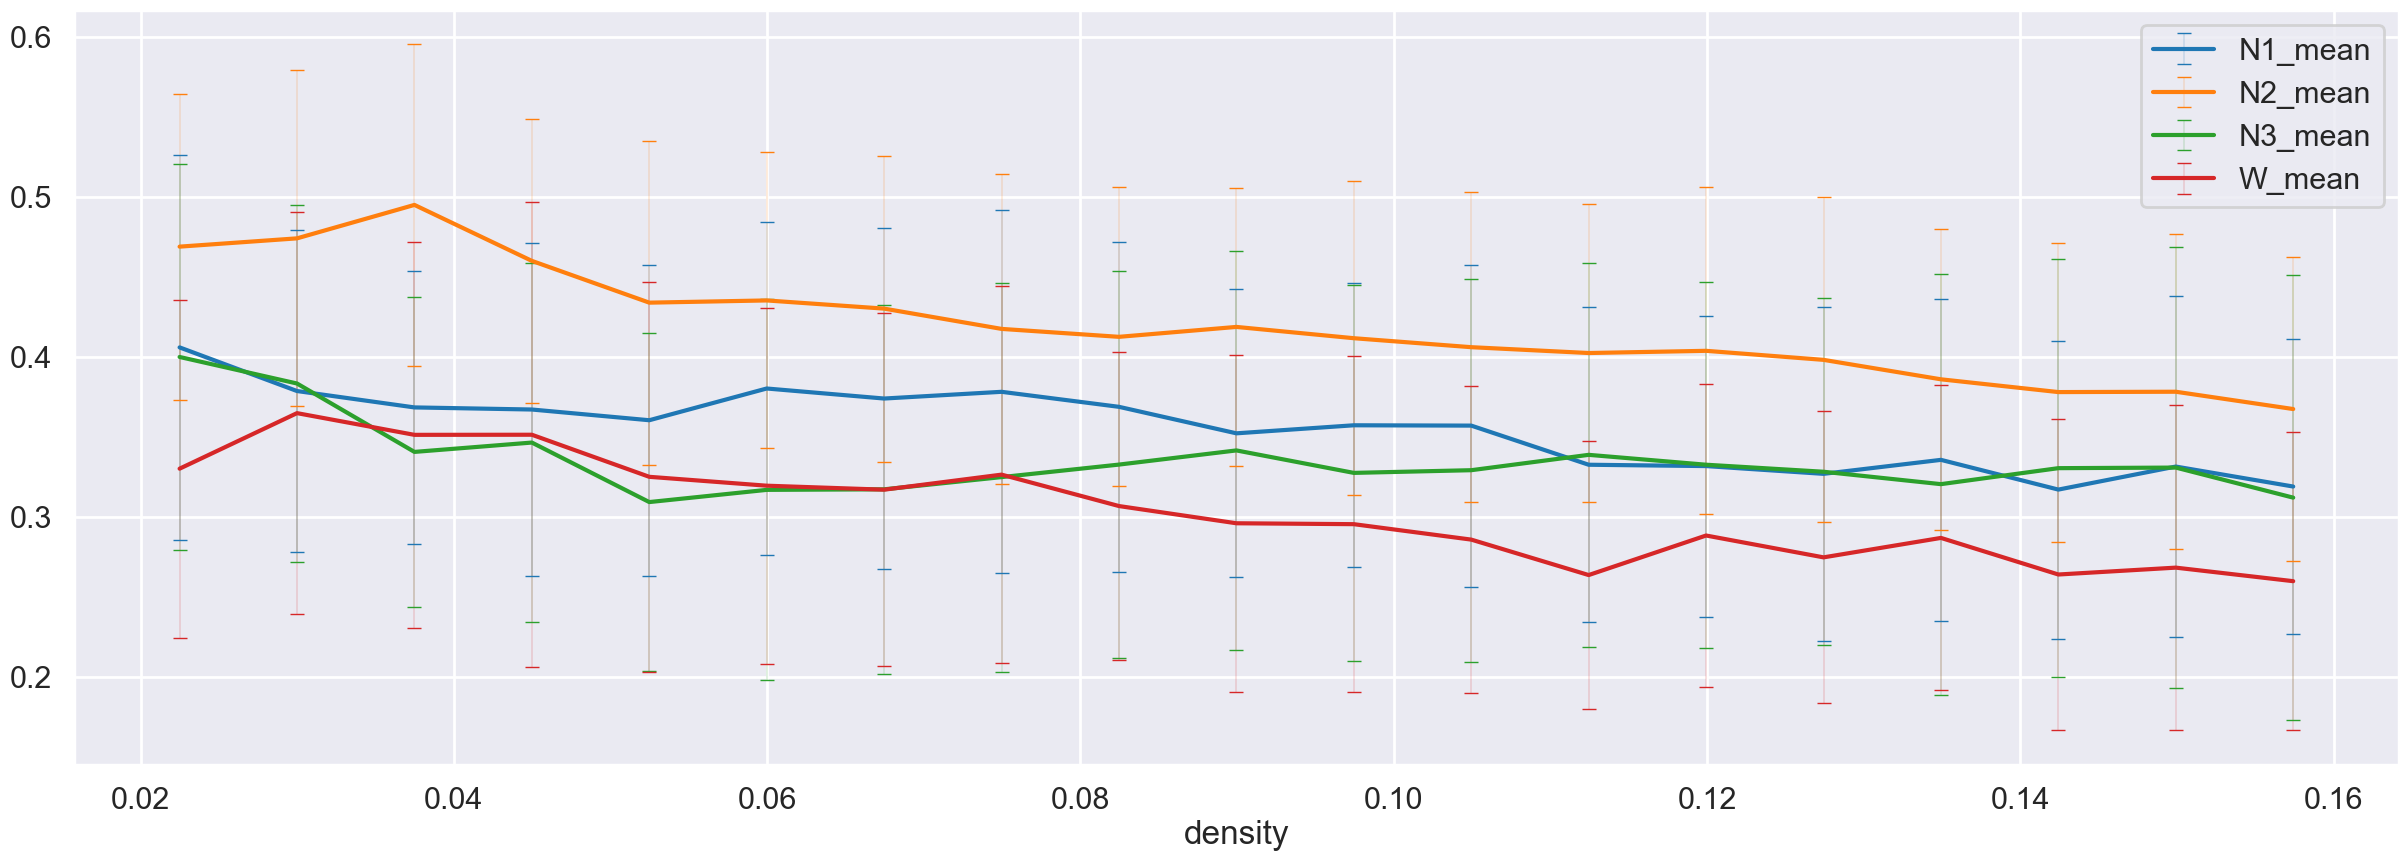

In [136]:
plt.rcParams['errorbar.capsize']=5

ax = rand_by_density.plot("density","N1_mean",yerr="N1_std",style='^-',elinewidth=.2,)
rand_by_density.plot("density","N2_mean",yerr="N2_std",ax=ax,style='^-',elinewidth=.2,)
rand_by_density.plot("density","N3_mean",yerr="N3_std",ax=ax,style='^-',elinewidth=.2,)
rand_by_density.plot("density","W_mean",yerr="W_std",ax=ax,style='^-',elinewidth=.2,)

In [12]:
def measure_rand_score_group_random_W(df_modulos, group='N1_', density=150):
    rand_list = []
    dict_modulos = []
    dict_modulos.append(df_modulos[density].filter(like=group, axis=0))
    dict_modulos.append(df_modulos[density].filter(like='W_', axis=0))
    r = itertools.combinations(dict_modulos[0].to_dict().keys(), 2)
    s = itertools.combinations(dict_modulos[1].to_dict().keys(), 2)

    for M1 in zip(r,s):        
        x = random.randint(0,1)
        #print(M1[0][0],M1[x][1])
        rand_score = adjusted_rand_score(df_modulos.loc[M1[0][0],density], df_modulos.loc[M1[x][1],density])
        #print(rand_score)
        rand_list.append(rand_score)
        #break
    return(rand_list)

In [13]:
measure_rand_score_group_random_W(df_modulos, group='N1_', density=150)

[0.3974377767702215,
 0.4104468574657894,
 0.36427950990867713,
 0.48268058255012114,
 0.260083769791394,
 0.5431833108746479,
 0.48735291178934587,
 0.4489457736441628,
 0.5474308486267807,
 0.1790184716842206,
 0.35476394214475754,
 0.4343310560645704,
 0.341488661073344,
 0.5897578584346833,
 0.6200821066931337,
 0.5868659730371621,
 0.33553941467236104,
 0.3833576062491725,
 0.49311628359779114,
 0.36416437652010786,
 0.2640504578303909,
 0.22132474575375177,
 0.38599786236338585,
 0.29092510094253143,
 0.3933754209127651,
 0.1071135655311936,
 0.3106429259981184,
 0.3677373235259843,
 0.4576889747004543,
 0.33791468356877585,
 0.352564944613843,
 0.3168031745188714,
 0.35698541344714496,
 0.3404828812295693,
 0.3551952837140752,
 0.19849839968891148,
 0.4041064835805428,
 0.48482311073895756,
 0.325941144480029,
 0.6266233766233766,
 0.12752469905924402,
 0.2605030008573878,
 0.28611375202729156,
 0.4078186849756542,
 0.4213192756649437,
 0.3732120810623626,
 0.28373211642821905,


In [45]:
random.seed(938413)

Np = 20

rand_df_list = []
rand_df_avg = rand_by_density.copy()
for kk in range(Np):
    print(kk)
    rand_by_density_dict = {}
    for edges_density in ds:
        rand_dict = {}
        rand = {}
        for state in sleep_states:
            rand[state] = measure_rand_score_group_random_W(df_modulos, group=state+'_', density=edges_density)
            rand_dict[state+"_mean"] = np.mean(rand[state])
            rand_dict[state+"_std"] = np.std(rand[state])
        rand_by_density_dict[edges_density] = rand_dict.copy()
    rand_df_ = pd.DataFrame(rand_by_density_dict).T
    rand_df_['density']=rand_df_.index/aristas_posibles
    rand_df_list.append(rand_df_)
    rand_df_avg = rand_df_avg+rand_df_
rand_by_density_random = rand_df_avg/(Np+1)

rand_by_density_random

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,N1_mean,N1_std,N2_mean,N2_std,N3_mean,N3_std,W_mean,W_std,density
150,0.381442,0.118505,0.413328,0.104839,0.371322,0.113132,0.330215,0.105643,0.022489
200,0.369648,0.100930,0.427115,0.111520,0.369384,0.103012,0.364949,0.125614,0.029985
250,0.364469,0.093281,0.442970,0.111748,0.348793,0.099035,0.351375,0.120769,0.037481
300,0.365371,0.110609,0.413582,0.106834,0.350698,0.112108,0.351439,0.145317,0.044978
350,0.356321,0.101857,0.394393,0.110986,0.315323,0.106236,0.325131,0.121980,0.052474
400,0.368858,0.102760,0.390596,0.101213,0.318448,0.112713,0.319577,0.111389,0.059970
450,0.369744,0.107088,0.394445,0.101461,0.325422,0.109817,0.317087,0.110552,0.067466
500,0.367898,0.110837,0.382620,0.100245,0.326713,0.114277,0.326495,0.117650,0.074963
550,0.358942,0.104749,0.378343,0.101271,0.327267,0.112337,0.306849,0.096202,0.082459
600,0.340269,0.095976,0.378498,0.096599,0.332786,0.115420,0.296081,0.105252,0.089955


In [130]:
resta = (rand_by_density)*0.0
for rand_df_ in rand_df_list:
    resta = resta+(rand_by_density<rand_df_)*1.0
pvalues = resta[['N1_mean','N2_mean','N3_mean']]/len(rand_df_)
pvalues['density']=pvalues.index/aristas_posibles

significancia = pvalues[pvalues<0.05]*0.0
significancia['density']=significancia.index/aristas_posibles

pvalues
significancia

,N1_mean,N2_mean,N3_mean,density
150,0.0,0.0,0.0,0.022489
200,0.0,0.0,0.0,0.029985
250,NaN,0.0,NaN,0.037481
300,NaN,0.0,NaN,0.044978
350,NaN,0.0,NaN,0.052474
400,0.0,0.0,NaN,0.059970
450,NaN,0.0,NaN,0.067466
500,0.0,0.0,NaN,0.074963
550,0.0,0.0,NaN,0.082459
600,0.0,0.0,0.0,0.089955


Text(0, 0.5, 'Índice de Rand ajustado Within-Group')

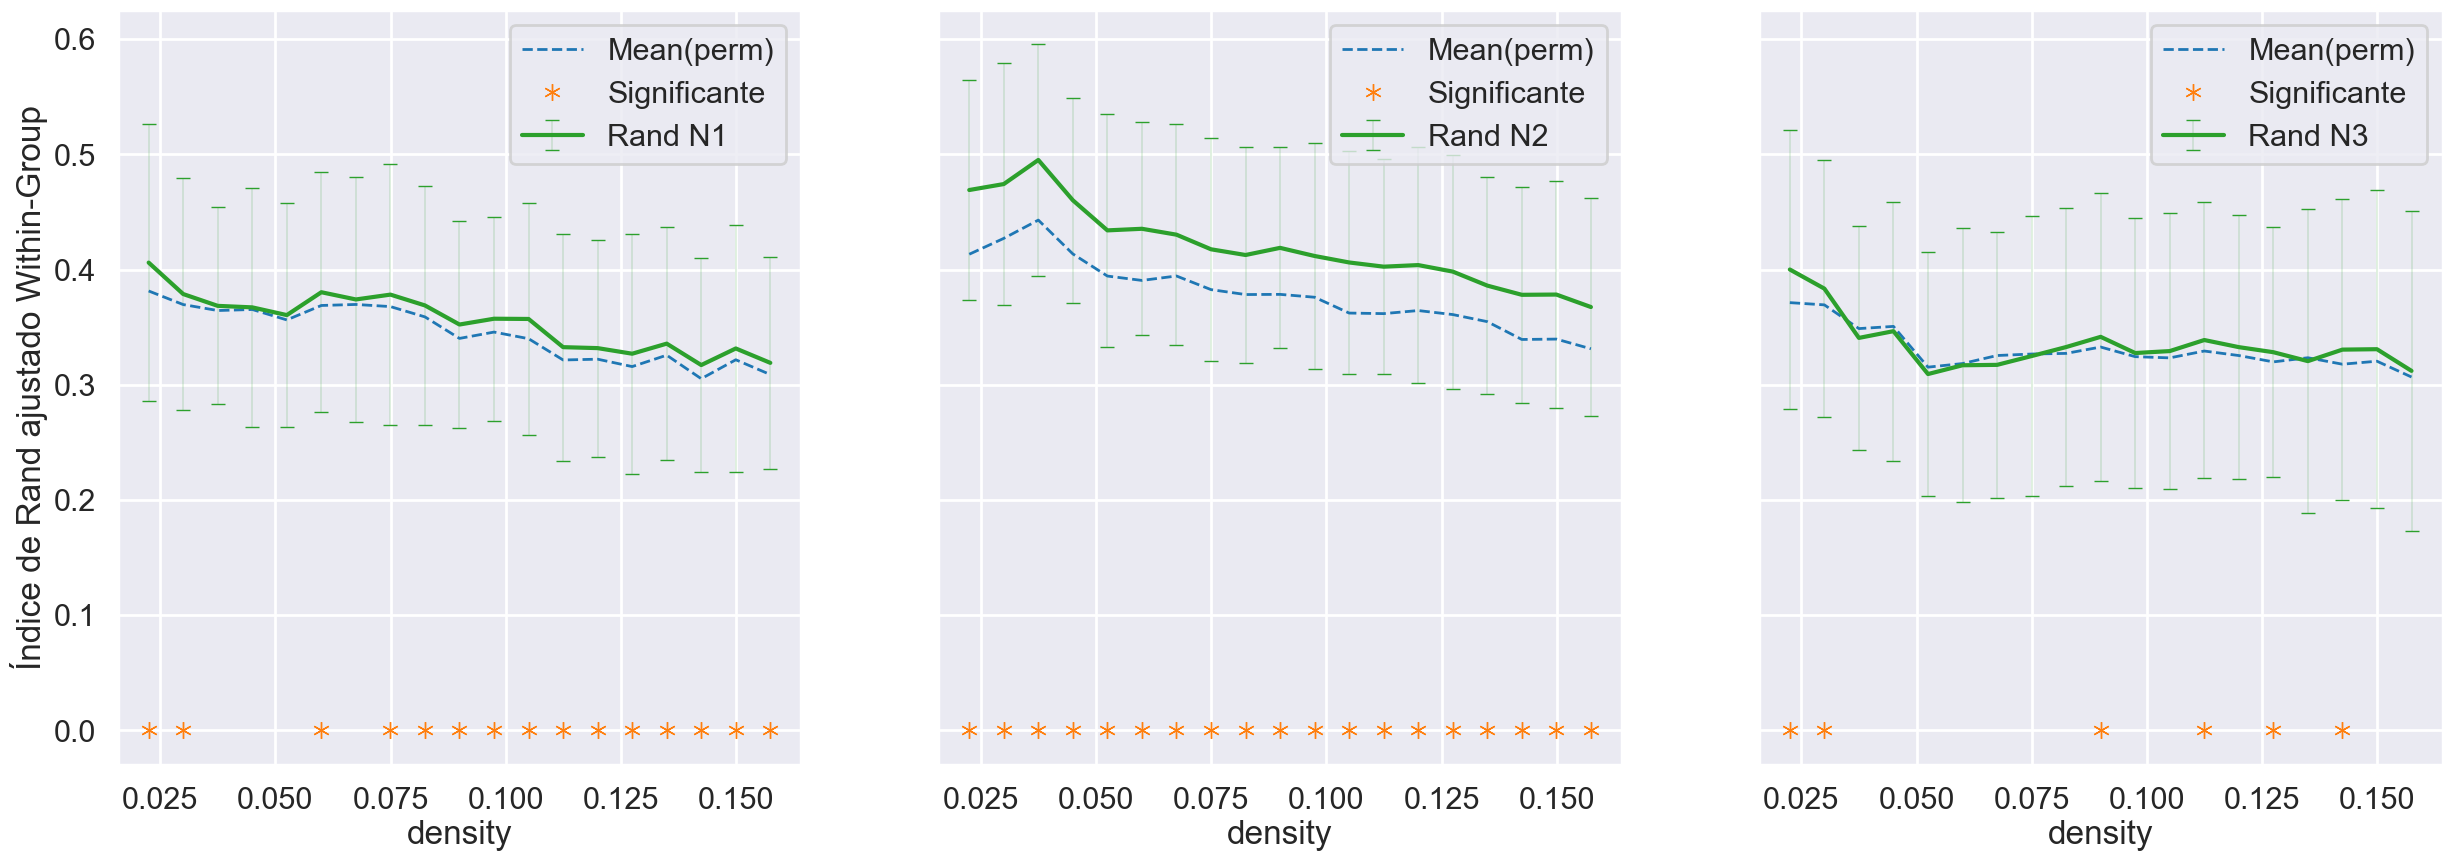

In [142]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

rand_by_density_random.plot("density","N1_mean",ax=ax1,style='--',label='Mean(perm)',linewidth=2)
rand_by_density_random.plot("density","N2_mean",ax=ax2,style='--',label='Mean(perm)',linewidth=2)
rand_by_density_random.plot("density","N3_mean",ax=ax3,style='--',label='Mean(perm)',linewidth=2)

significancia.plot("density","N1_mean" , linestyle='',marker=(6, 2, 0),ax=ax1,label='Significante')
significancia.plot("density","N2_mean" , linestyle='',marker=(6, 2, 0),ax=ax2,label='Significante')
significancia.plot("density","N3_mean" , linestyle='',marker=(6, 2, 0),ax=ax3,label='Significante')

rand_by_density.plot("density","N1_mean",yerr="N1_std",ax=ax1,style='^-',label='Rand N1',elinewidth=.2,)
rand_by_density.plot("density","N2_mean",yerr="N2_std",ax=ax2,style='^-',label='Rand N2',elinewidth=.2,)
rand_by_density.plot("density","N3_mean",yerr="N3_std",ax=ax3,style='^-',label='Rand N3',elinewidth=.2,)


ax1.set_ylabel('Índice de Rand ajustado Within-Group')

Si es significante, esto implica que hay un patrón en el agrupamiento que se hace en el estado Nx, y que es significativamente distinto al agrupamiento que se hace en W, y dicha diferencia no es causada por un factor aleatorio.